# Using the virtual dot array

In this example we use the virtual dot array to show how to perofrm measurements and analysis using QTT. For a real device the measurements and analysis will go exactly the same (although you will have more noise and the scans will have more distortions).

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tempfile

import qcodes
from qcodes import QtPlot
from qcodes import MatPlot

import qtt
from qtt import createParameterWidget
from qtt.algorithms.gatesweep import analyseGateSweep
from qtt.measurements.scans import scanjob_t
from qtt.instrument_drivers.virtual_gates import virtual_gates, create_virtual_matrix_dict

from qtt import save_state, load_state
import qtt.measurements.videomode

import qtt.simulation.virtual_dot_array

np.set_printoptions(precision=2, suppress=True)
datadir = tempfile.mkdtemp(prefix='qtt_example')
qcodes.DataSet.default_io = qcodes.DiskIO(datadir)

## Create a virtual model for testing

 The model resembles the spin-qubit dot setup. The hardware consists of a virtual
 keithley, IVVI racks and a virtual gates object

In [3]:
nr_dots = 3
station = qtt.simulation.virtual_dot_array.initialize(reinit=True, nr_dots=nr_dots, maxelectrons=2)
print(station.components.keys())

initialize: create virtualdot
initialized virtual dot system (3 dots)
dict_keys(['gates', 'keithley1', 'keithley3', 'keithley4', 'ivvi1', 'ivvi2', 'vawg', 'sdigitizer'])


In [6]:
keithley1 = station.keithley1
keithley3 = station.keithley3

gates = station.gates

## Simple 1D scan loop

scan1D: 0/627: time 0.0
scan1D: 409/627: time 1.5
DataSet:
   location = '2018-08-18/14-41-56_qtt_scan1D'
   <Type>   | <array_id>          | <array.name>        | <array.shape>
   Measured | keithley3_amplitude | keithley3_amplitude | (627,)
   Setpoint | B3                  | B3                  | (627,)


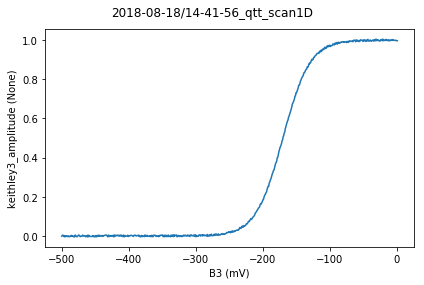

In [12]:
param_left=station.model.bottomgates[0]
param_right=station.model.bottomgates[-1]
scanjob = scanjob_t({'sweepdata': dict({'param': param_right, 'start': -500, 'end': 1, 'step': .8, 'wait_time': 3e-3}), 'minstrument': ['keithley3.amplitude']})
data1d = qtt.measurements.scans.scan1D(station, scanjob, location=None, verbose=1)

print(data1d)

_ = qcodes.MatPlot(data1d.default_parameter_array())

## Fit 1D pinch-off scan:

analyseGateSweep: leftval 0.0, rightval 0.3


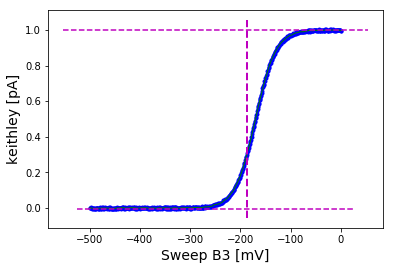

In [13]:
adata = analyseGateSweep(data1d, fig=100)

## Make a 2D scan

scan2D: 0/80: time 00:00:00 (~00:00:00 remaining): setting B0 to -500.000
scan2D: 75/80: time 00:00:01 (~00:00:00 remaining): setting B0 to -125.000


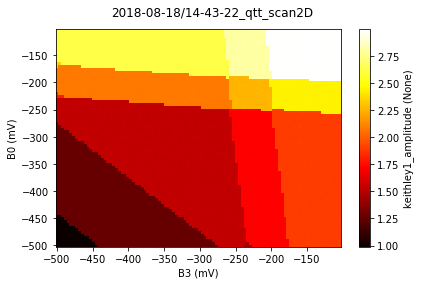

In [14]:
start = -500
scanjob = scanjob_t({'sweepdata': dict({'param': param_right, 'start': start, 'end': start + 400, 'step': 4., 'wait_time': 0.}), 'minstrument': ['keithley1.amplitude']})
scanjob['stepdata'] = dict({'param': param_left, 'start': start, 'end': start + 400, 'step': 5.})
data2d = qtt.measurements.scans.scan2D(station, scanjob)

_ = qcodes.MatPlot(data2d.default_parameter_array())

In [35]:
gv={'B0': -300.000,'B1': 0.145,'B2': -0.357,'B3': -300.000,'D0': 0.085,'O1': 0.222,'O2': -0.403,'O3': 0.117,'O4': -0.275,'O5': -0.163,'P1': 30.,'P2': -40,'P3': -0.072,'SD1a': 0.254,'SD1b': -0.442,'SD1c': 0.252,'bias_1': 0.337,'bias_2': -0.401}
gates.resetgates(gv, gv)

resetgates: setting gates to default values
  setting gate B0 to -300.0 [mV]
  setting gate B1 to 0.1 [mV]
  setting gate B2 to -0.4 [mV]
  setting gate B3 to -300.0 [mV]
  setting gate D0 to 0.1 [mV]
  setting gate O1 to 0.2 [mV]
  setting gate O2 to -0.4 [mV]
  setting gate O3 to 0.1 [mV]
  setting gate O4 to -0.3 [mV]
  setting gate O5 to -0.2 [mV]
  setting gate P1 to 30.0 [mV]
  setting gate P2 to -40.0 [mV]
  setting gate P3 to -0.1 [mV]
  setting gate SD1a to 0.3 [mV]
  setting gate SD1b to -0.4 [mV]
  setting gate SD1c to 0.3 [mV]
  setting gate bias_1 to 0.3 [mV]
  setting gate bias_2 to -0.4 [mV]


## Make virtual gates

Instread of scanning physical gates, we can also scan linear combinations of gates. We use the `virtual_gates` object to define linear combinations and make scans.

In [42]:
gates.resetgates(gv, gv, 0)

c = np.array([[1,.56,.15],[.62,1,.593],[.14,.62,1.]])
crosscap_map = create_virtual_matrix_dict(['vP1', 'vP2', 'vP3'], ['P1', 'P2', 'P3'], c=c)
virts = virtual_gates(qtt.measurements.scans.instrumentName('vgates'), gates, crosscap_map)
virts.print_matrix()

create_virtual_matrix_dict: adding vP1 
create_virtual_matrix_dict: adding vP2 
create_virtual_matrix_dict: adding vP3 
	P1	P2	P3
vP1	1	0.56	0.15
vP2	0.62	1	0.593
vP3	0.14	0.62	1


scan2D: 0/100: time 00:00:00 (~00:00:00 remaining): setting vP2 to -150.000


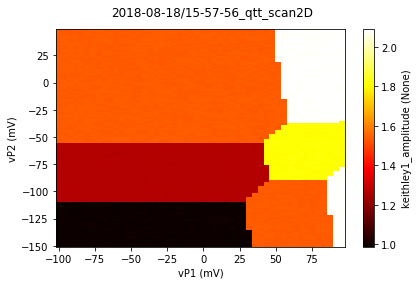

In [45]:
r=100
scanjob = scanjob_t({'sweepdata': dict({'param': virts.vP1, 'start': -r, 'end': r, 'step': 4.}), 'minstrument': ['keithley1.amplitude']})
scanjob['stepdata'] = dict({'param': virts.vP2, 'start': -50 - r, 'end': -50 +r, 'step': 2.})
data_virtual_gates = qtt.measurements.scans.scan2D(station, scanjob)

_ = qcodes.MatPlot(data_virtual_gates.default_parameter_array())